In [1]:
pip install pmdarima

In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
from datetime import datetime
import plotly.express as px
import pmdarima as pm
import itertools
from pylab import rcParams
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False


from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
ls'/content/gdrive/My Drive/Thesis'

dataframe_dma_flow_1D.csv     dataframe_flow_variable_1D.csv     DMA_468.csv
dataframe_dma_flow_60min.csv  dataframe_flow_variable_60min.csv
dataframe_flow_1D.csv         DMA_225.csv


In [5]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/DMA_225.csv")
data['Date-time'] = pd.to_datetime(data['Date-time'], dayfirst=True, errors='coerce')
data.rename( columns={'Flow':'DMA_225','Date-time':'Date_time'}, inplace=True )
data_DMA225 = data[['Date_time','DMA_225']]

In [6]:
figure = px.line(data_DMA225,x="Date_time",y="DMA_225",title="DMA_225 with slider")
figure.update_xaxes(rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=2,
                     label="2m",
                     step="month",
                     stepmode="backward"),
                dict(count=3,
                     label="3m",
                     step="month",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        )
    )
figure.show()

In [7]:
data_DMA225_indexed = data_DMA225.set_index('Date_time')
hourly_data = data_DMA225_indexed.resample('h').sum()
hourly_data.shape

(8760, 1)

# Stationarity check

<Figure size 1584x720 with 0 Axes>

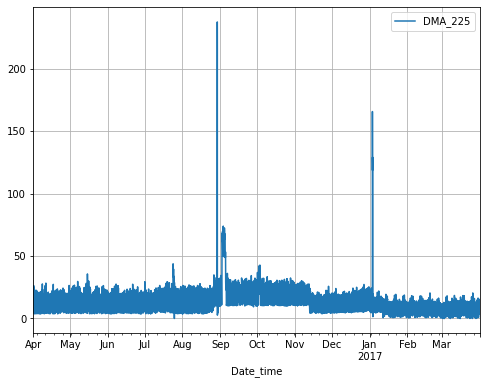

<Figure size 1584x720 with 0 Axes>

In [8]:
# Looking at plots
DMA225_df_indexed = hourly_data[['DMA_225']]
DMA225_df_indexed.plot(grid=True)
plt.figure(figsize=(22,10))

In [9]:
# Augmented Dickey-Fuller test
#Null Hypothesis (H0): If failed to be rejected, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): The null hypothesis is rejected;  meaning it is stationary. It does not have time-dependent structure.

ADF_Check_Stationary = adfuller(hourly_data)
print('ADF Statistic: %f' % ADF_Check_Stationary[0])
print('p-value: %f' % ADF_Check_Stationary[1])
print('Critical Values:')
for key, value in ADF_Check_Stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.013940
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Observation :

1.The ADF statistic value of -7. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

2.p value - 0.000058 < 0.05 ; Data is stationary

In [10]:
#Kwiatkowski-Phillips-Schmidt-Shin test
#Null Hypothesis (H0): stationary.
#Alternate Hypothesis (H1): non-stationary

KPSS_Check_Stationary = kpss(hourly_data)
KPSS_Check_Stationary

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




(4.31149360491682,
 0.01,
 37,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Observation : 1.The ADF statistic value of 4.3. The positive value is statistic, and hence we have a stationary dataset.

# Time series decomposition

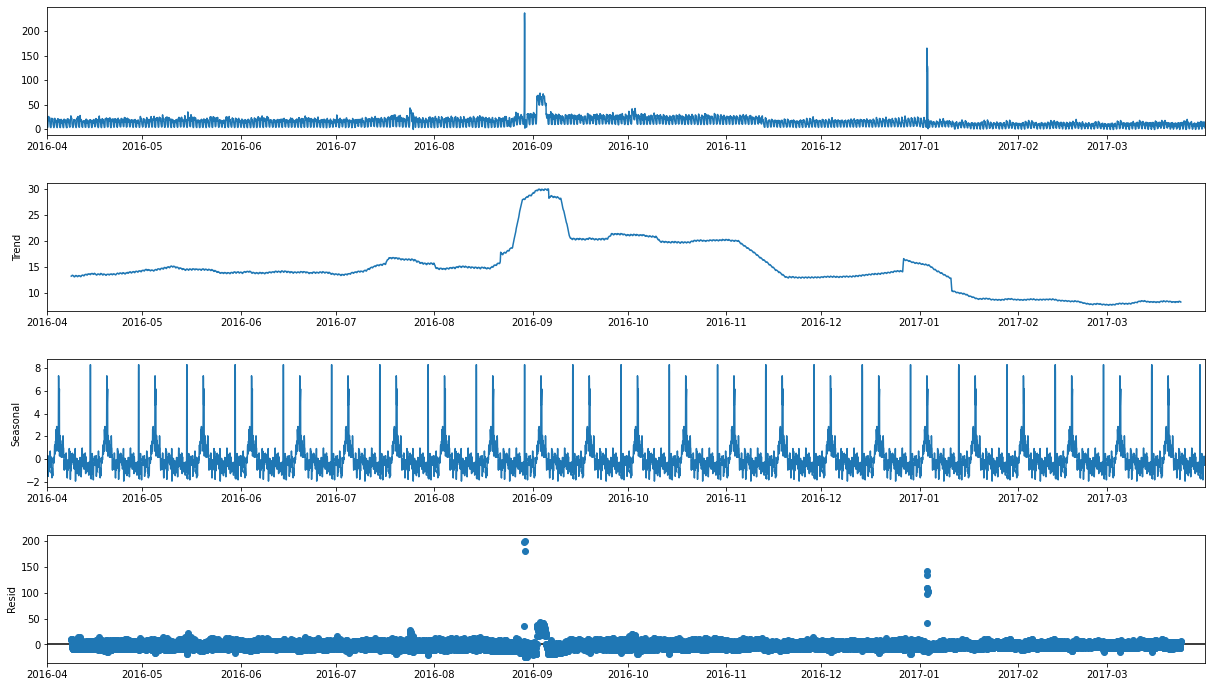

In [11]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(hourly_data,period=365)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(18)
plt.show()

# Baseline model : 
one step ahead prediction 

In [12]:
# Making a df
Original = hourly_data["DMA_225"].to_frame().rename(columns = {"DMA_225": "Original" })
Forecast  = hourly_data["DMA_225"].to_frame().shift(1).rename(columns = {"DMA_225": "Forecast" })
baseline = pd.concat([Original,Forecast],axis=1)
final = baseline[1:]#there is no prediction for first row due to shifting.
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(final.Original, final.Forecast))
rmse = round(rmse, 3)
print (" The root mean square value on dataset: ",rmse)


 The root mean square value on dataset:  4.425


<Figure size 1584x720 with 0 Axes>

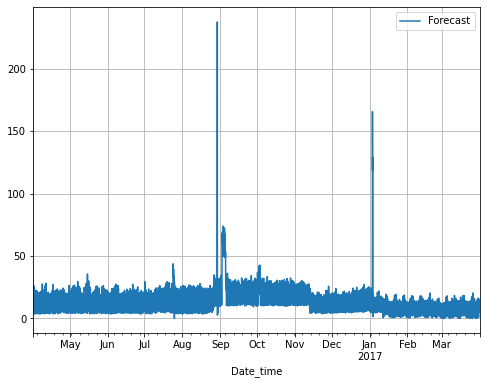

<Figure size 1584x720 with 0 Axes>

In [22]:
one_step_forecast = final[['Forecast']]
one_step_forecast.plot(grid=True)
plt.figure(figsize=(22,10))

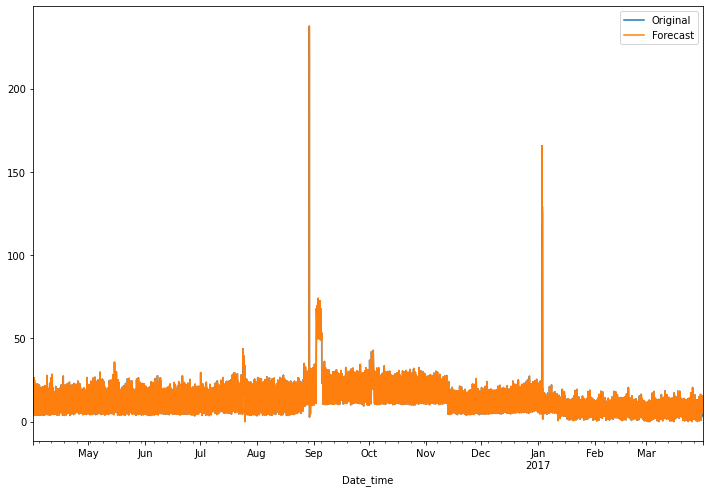

In [13]:
final.plot(figsize=(12,8))

 The root mean square value on dataset:  2.533


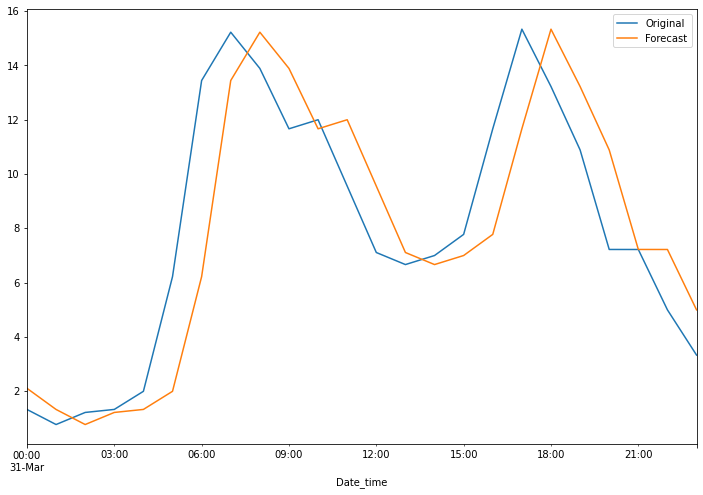

In [14]:
baseline_graph = final[-24:]
rmse1 = np.sqrt(mean_squared_error(baseline_graph.Original, baseline_graph.Forecast))
rmse1 = round(rmse1, 3)
print (" The root mean square value on dataset: ",rmse1)
baseline_graph.plot(figsize=(12,8))

# Sarimax

In [15]:
# Dataset is divided into 60% train, 40% test set:
# train = hourly_data[:5256]
# test = hourly_data[5356:]

# train = hourly_data[:7008]
# test = hourly_data[7008:]

In [16]:
# Getting best arima model 
p = d = q = range(0, 2)
pdq_cal = list(itertools.product(p, d, q))
# generation of different combinations of seasonal p, q and q triplets
pdq_seasonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
aic_bestvalue = np.inf
pdq_bestvalue = None
pdq_seasonal_best = None
tempmodel = None
for params in pdq_cal:   
    for seasonal_params in pdq_seasonal: 
        tempmodel = SARIMAX(hourly_data['DMA_225'],order=params,seasonal_order = seasonal_params,enforce_invertibility=False,enforce_stationarity=False)
        results = tempmodel.fit(disp=False)
        if results.aic < aic_bestvalue:
            aic_bestvalue = results.aic
            pdq_bestvalue = params
            pdq_seasonal_best = seasonal_params
print("Best ARIMA with seasonality (SARIMAX) {} x {} model - AIC:{}".format(pdq_bestvalue,pdq_seasonal_best,aic_bestvalue))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Best ARIMA with seasonality (SARIMAX) (1, 0, 1) x (1, 1, 1, 12) model - AIC:48654.26552054069


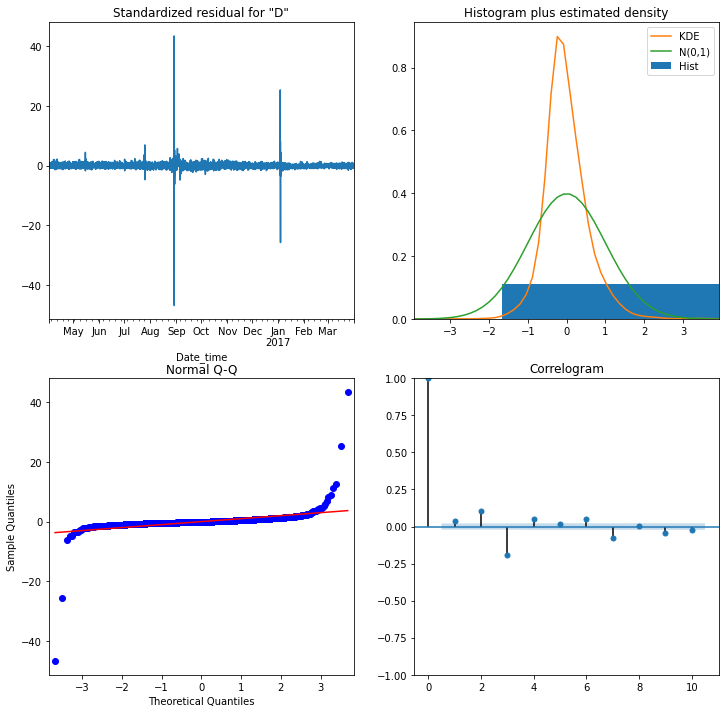

In [17]:
# Training the model on the full dataset and predict last 24 hours output
model =  SARIMAX(hourly_data['DMA_225'], 
                        order = (1, 0, 1), 
                        seasonal_order =(1, 1, 1, 12),enforce_invertibility=False,
                             enforce_stationarity=False)
sarimax = model.fit()
sarimax.plot_diagnostics(figsize=(12, 12))
plt.show()

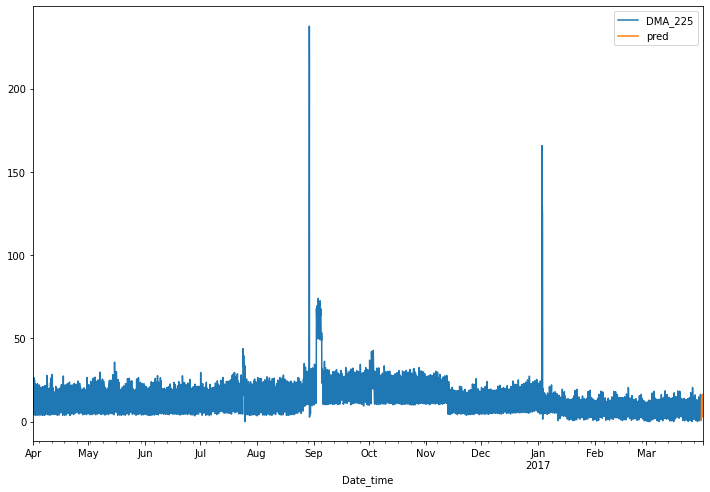

In [18]:
# Predicting 24 hours:
forecast= sarimax.get_prediction(start=pd.to_datetime('2017-03-31'), dynamic=False)
hourly_data['pred'] = sarimax.predict(start=pd.to_datetime('2017-03-31'), dynamic=False)
hourly_data[['DMA_225','pred']].plot(figsize=(12,8))

In [19]:
# Calculate the RMSE
cv = hourly_data[-24:]
rmse2 = np.sqrt(mean_squared_error(cv.DMA_225, cv.pred))
rmse2 = round(rmse2, 3)
print (" The root mean square value on dataset using sarimax: ",rmse2)

 The root mean square value on dataset using sarimax:  1.582


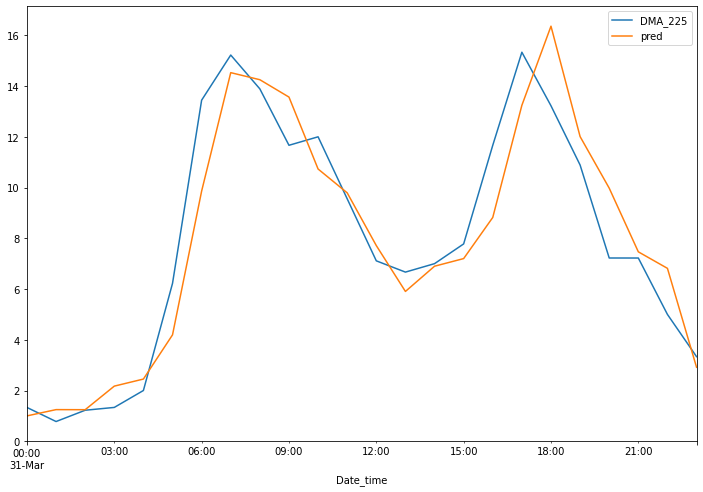

In [20]:
cv.plot(figsize=(12,8))